# Pytorch

## ResNet
___Transfer keras to pytorch___

keras resnet, my model  
_https://github.com/jujemu/GoingHigher/blob/master/2/%5BGD_2%5DResNet.ipynb_  
(immature implementation)

## Using tf.data.Dataset, train torch model
_Almost gave up due to Using tensorflow dataset_  :l  
</br>

Unfortunately, I cant find any solution, So I do  
Using kaggle dataset: cats_vs_dogs  
_https://www.kaggle.com/competitions/dogs-vs-cats/data_


Reference  
 - how to use Dataset in Tensorflow: built-in API  
_https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428_

In [2]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/Pytorch'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np

import os
from glob import glob

In [6]:
from tqdm import tqdm
import shutil

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


## Dataset

### Fail

#### Loading Dataset from tensorflow_datasets
_Fail_

In [ ]:
# setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# ds, info = tfds.load(
#       'cats_vs_dogs',
#       data_dir=drive_path,
#       split='train',
#       download=True,
#       as_supervised=True,
#       with_info=True
# )

In [ ]:
# info

In [ ]:
# # for img, label in ds: break
# tf.shape(img)

In [ ]:
# ds = tfds.as_numpy(ds)
# ds

#### Custom DataLoader
_Fail_  

What is problem for me is 'cannot define \__getitem\__ of CustomDataset',  
bacause of tensorflow dataset has no index of dataset

In [ ]:
# class CustomDataset(torch.utils.data.Dataset):
#   def __init__(self, train=True, transform=None):
#     if train:
#       ds, self.info = tfds.load(
#         'cats_vs_dogs',
#         split='train[:80%]',
#         as_supervised=True,
#         download=True,
#         data_dir=drive_path,
#         with_info=True)      
#     else:
#       ds, self.info = tfds.load(
#         'cats_vs_dogs',
#         split='train[80%:]',
#         as_supervised=True,
#         download=True,
#         data_dir=drive_path,
#         with_info=True)
      
#     self.transform = transform
    
#     # Image get into list
#     self.dataset = np.array(tfds.as_numpy(ds.map(lambda x, _ : x)))
#     self.dataset = tfds.as_numpy(ds)
#     self.label = np.array(tfds.as_numpy(ds.map(lambda _, x: x.numpy())))
      
#   def __len__(self):
#     return len(self.dataset)

#   def __getitem__(self, idx):
#     image, label = self.dataset[idx], self.label[idx]
#     if self.transform:
#       image = self.transform(image)
#     item = {'image': image, 'label': label}
#     return item

In [ ]:
# transform = T.Compose([
#     T.ToTensor(),
#     T.Resize(size=224),
#     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [ ]:
# it takes a bit time
# due to converting tensorflow datasets to torch tensor
# train_ds = CustomDataset(train=True, transform=transform)
# train_ds

AttributeError: ignored

### Using kaggle Dataset

Reference  
_https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/_

#### Command Line

In [ ]:
%%capture
!pip install kaggle

In [ ]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download dogs-vs-cats

 99% 800M/812M [00:08<00:00, 136MB/s]
100% 812M/812M [00:08<00:00, 99.9MB/s]


In [ ]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip test1.zip

In [ ]:
!unzip train.zip

In [ ]:
!rm test1.zip

In [ ]:
!rm train.zip

In [ ]:
drive_path

'/content/drive/MyDrive/Colab Notebooks/Pytorch'

In [ ]:
!cp sampleSubmission.csv '/content/drive/MyDrive/Colab Notebooks/Pytorch/ResNet'

In [ ]:
!cp -r train/ '/content/drive/MyDrive/Colab Notebooks/Pytorch/ResNet'

^C


In [ ]:
!cp -r test1 '/content/drive/MyDrive/Colab Notebooks/Pytorch/ResNet/'

^C


### torch CustomDataset
_https://pytorch.org/tutorials/beginner/data_loading_tutorial.html_

How to split train-validation dataset with shuffle  
_https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb_

In [30]:
cat = glob(drive_path +'/ResNet/train/cat.*')
dog = glob(drive_path +'/ResNet/train/dog.*')
len(cat), len(dog)

(12499, 12500)

In [37]:
!mkdir -p '/content/data/train/cat'
!mkdir -p '/content/data/train/dog'

In [33]:
for i in tqdm(cat):
  shutil.copy(i, '/content/data/train/cat')

In [34]:
for i in tqdm(dog):
  shutil.copy(i, '/content/data/train/dog')

In [42]:
shutil.copytree(drive_path+'/ResNet/test1/', '/content/data/test')

'/content/data/test'

In [35]:
# dataset has 12,500 cat images, 12,500 dog images
# train_path = drive_path + '/ResNet/train/*'
train_path = '/content/data/train'

In [36]:
# train data 검증
# empty file 걸러내기
list_train = glob(train_path + '/cat/*')
for path in list_train:
  if os.stat(path).st_size == 0:
    print(path)

list_train = glob(train_path + '/dog/*')
for path in list_train:
  if os.stat(path).st_size == 0:
    print(path)

In [43]:
# test data 검증
list_test = glob('/content/data/test/*')
for path in list_test:
  if os.stat(path).st_size == 0:
    print(path)

In [ ]:
# delete empty image files
# os.remove('/content/data/train/cat.10981.jpg')
# os.remove('/content/data/test/1034.jpg')

In [ ]:
# shape of each image is not same
sample_path = list_train[0]
sample = torchvision.io.read_image(sample_path)
sample.shape

torch.Size([3, 370, 288])

In [8]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir='/content/data',train=True, transform=None):
    self.transform = transform
    self.train = train

    if self.train:
      path = data_dir + '/train/*'
    else:
      path = data_dir + '/test1/*'    
    self.list_image = glob(path)
      
  def __len__(self):
    return len(self.list_image)

  def __getitem__(self, idx):
    image_path = self.list_image[idx]
    image = torchvision.io.read_image(image_path)
    if self.train:
      label = 1 if 'cat' in image_path else 0
    else: label = None
    
    if self.transform:
      image = self.transform(image)
    item = image, label
    return item

transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ConvertImageDtype(torch.float),
    T.Normalize((0., 0., 0.), (255., 255., 255.))
])

In [9]:
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ConvertImageDtype(torch.float),
    T.Normalize((0., 0., 0.), (255., 255., 255.))
])

In [12]:
train_ds = CustomDataset(train=True, transform=transform)
test_ds = CustomDataset(train=False, transform=transform)
len(train_ds), len(test_ds)

(24999, 12499)

In [12]:
indices = np.arange(len(train_ds))
np.random.shuffle(indices)
indices

array([24479,  8501,  8898, ..., 16660, 17291, 21650])

In [13]:
val_size = int(len(indices) * 0.2)
val_idx, train_idx = indices[:val_size], indices[val_size:]
len(val_idx), len(train_idx)

(4999, 20000)

In [14]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [13]:
# dataloader
batch_size = 32
trainloader = torch.utils.data.DataLoader(train_ds, batch_size, num_workers=2)
# trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler, num_workers=2)
# valloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=val_sampler, num_workers=2)

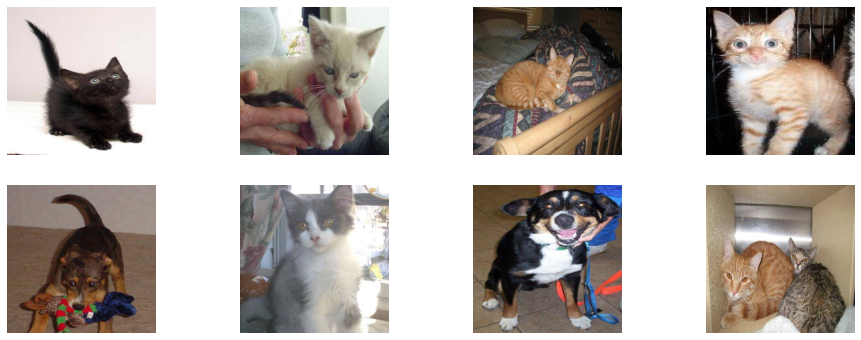

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(16, 6))
ax = ax.flatten()

for i in range(8):  
  if i < 4:
    idx = np.random.randint(len(train_ds)//2)
    sample = torch.mul(train_ds[idx][0], 255)
    sample = sample.permute(1,2,0)
  else:
    idx = np.random.randint(len(train_ds)//2) + (len(train_ds)//2)
    sample = torch.mul(train_ds[idx][0], 255)
    sample = sample.permute(1,2,0)
  ax[i].imshow(sample)
  ax[i].axis(False)
plt.show()

## Modeling

In [14]:
class BottleNeck(nn.Module):
  def __init__(self, in_channels, out_channels, downsample=None, stride=1):
    super().__init__()
    self.downsample = downsample

    self.conv1 = nn.Conv2d(in_channels, out_channels, 1, 1, padding='same', bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.conv3 = nn.Conv2d(out_channels, out_channels*4, 1, 1, padding='same', bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels*4)
    self.relu = nn.ReLU()

  def forward(self, x):
    identity = x.clone()
    if self.downsample:
      identity = self.downsample(identity)

    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))

    # residual
    x += identity
    return self.relu(x)

In [15]:
class ResNet50(nn.Module):
  def __init__(self, num_layers=[3,4,6,3], donw_in_channels=64, num_classes=2):
    super().__init__()
    self.down_in_channels = 64
    self.plane = 64
    num_layer = iter(num_layers)

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.relu = nn.ReLU()

    # BottleNeck Layers
    self.layer1 = self._make_layer(next(num_layer))
    self.layer2 = self._make_layer(next(num_layer), stride=2)
    self.layer3 = self._make_layer(next(num_layer), stride=2)
    self.layer4 = self._make_layer(next(num_layer), stride=2)

    self.GAP = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(2048, num_classes)

  def _make_layer(self, num_layer, stride=1):
    layer = []
    downsample = nn.Sequential(
        nn.Conv2d(self.down_in_channels, self.plane*4, 1, stride, bias=False),
        nn.BatchNorm2d(self.plane*4)
    )
    layer.append(BottleNeck(self.down_in_channels, self.plane, downsample, stride=stride))

    for _ in range(num_layer-1):
      layer.append(BottleNeck(self.plane*4, self.plane))
    
    self.down_in_channels = self.plane * 4
    self.plane *= 2
    return nn.Sequential(*layer)
  
  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.pool(x)

    # BottleNeck Layers
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.GAP(x)
    x = x.reshape(x.shape[0], -1)
    return self.fc(x)

In [16]:
# weight initialization 'he initial'
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')

In [17]:
model = ResNet50().to(device)
model.apply(initialize_weights)
print()

### model summary

In [18]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
            Conv2d-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [20]:
def train(model, loader, loss_fn, optimizer):
  size = len(loader.dataset)
  model.train()

  cnt = 0
  for idx, (inputs, labels) in enumerate(loader, 1):
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    num = len(loader)// 5
    cnt += idx*num*len(labels)
    if idx % num == 0:
      print(f'Loss: {loss.item():.3f} [{cnt/size*100:.2f}%]')
      print()      
  print(f'Loss: {loss.item():.3f}')

In [21]:
def test(model, loader, loss_fn):
  size = len(loader.dataset)
  num_batches = len(loader)
  model.eval()
  
  total_loss = []
  correct = []
  with torch.no_grad():
    for idx, (inputs, label) in enumerate(loader):
      inputs, label = inputs.to(device), label.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, label).item()

      total_loss.append(loss)
      correct.append((outputs.argmax(1) == label).sum().type(torch.float).item())

  loss = np.sum(total_loss)/num_batches
  acc = np.sum(correct)/size
  print('Test')  
  print(f'Avg Loss: {loss:.4f}')  
  print(f'Accuracy: {acc:.4f}')
  return loss, acc

### training

In [22]:
epochs = 10
writer = SummaryWriter()

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch+1}')
  print('-----------------------')
  train(model, trainloader, loss_fn, optimizer)
  # loss, acc = test(model, valloader, loss_fn)
  # writer.add_scalar('Validation Loss', loss, epoch)
  # writer.add_scalar('Validation Accuracy', acc, epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-----------------------
1
2
3
4
5
6
7
8


  0%|          | 0/10 [03:09<?, ?it/s]


KeyboardInterrupt: ignored

### history
_refered to https://gaussian37.github.io/dl-pytorch-observe/_

In [ ]:
a = np.sum([1,2,3,4])
a

10